## Retail Customer Intelligence
This project builds a customer intelligence workflow from transaction data to support better customer decisions across the lifecycle: identifying meaningful customer groups, prioritizing retention efforts, and estimating near-term customer value. This system inlcudes segmentation that explains who the customers are, churn predicts who is at risk, and CLV estimates who is worth saving.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

PROJECT_ROOT = Path("..")
RAW_PATH = PROJECT_ROOT / "data" / "raw" / "online_retail_II.xlsx"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

RAW_PATH


WindowsPath('../data/raw/online_retail_II.xlsx')

In [2]:
### Load the dataset
xls = pd.ExcelFile(RAW_PATH)
xls.sheet_names

['Year 2009-2010', 'Year 2010-2011']

In [8]:
df_list = []
for sheet in xls.sheet_names:
    tmp = pd.read_excel(RAW_PATH, sheet_name=sheet)
    tmp["source_sheet"] = sheet
    df_list.append(tmp)

raw = pd.concat(df_list, ignore_index=True)

raw.head()
raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Invoice       1067371 non-null  object        
 1   StockCode     1067371 non-null  object        
 2   Description   1062989 non-null  object        
 3   Quantity      1067371 non-null  int64         
 4   InvoiceDate   1067371 non-null  datetime64[us]
 5   Price         1067371 non-null  float64       
 6   Customer ID   824364 non-null   float64       
 7   Country       1067371 non-null  str           
 8   source_sheet  1067371 non-null  str           
dtypes: datetime64[us](1), float64(2), int64(1), object(3), str(2)
memory usage: 73.3+ MB


In [ ]:
## Data Cleaning and Preparation
# Standardize columns + parse dates
import re

def standardize_columns(cols):
    out = []
    for c in cols:
        c = c.strip()
        # Insert underscore between lower->upper: InvoiceDate -> Invoice_Date
        c = re.sub(r"([a-z0-9])([A-Z])", r"\1_\2", c)
        c = c.lower()
        c = c.replace(" ", "_")
        c = c.replace("-", "_")
        out.append(c)
    return out

raw.columns = standardize_columns(raw.columns)
raw.columns

raw["invoice_date"] = pd.to_datetime(raw["invoice_date"], errors="coerce")
raw.isnull().sum()

invoice              0
stock_code           0
description       4382
quantity             0
invoice_date         0
price                0
customer_id     243007
country              0
source_sheet         0
dtype: int64

In [12]:
raw.columns

Index(['invoice', 'stock_code', 'description', 'quantity', 'invoice_date', 'price', 'customer_id', 'country', 'source_sheet'], dtype='str')

In [ ]:
## Flags + revenue + summary
raw["invoice"] = raw["invoice"].astype(str)
raw["is_cancelled"] = raw["invoice"].str.startswith("C")
raw["is_return"] = raw["quantity"] < 0

if "unit_price" not in raw.columns and "price" in raw.columns:
    raw["unit_price"] = raw["price"]

raw["revenue"] = raw["quantity"] * raw["unit_price"]

raw_summary = pd.DataFrame([{
    "rows": len(raw),
    "min_date": raw["invoice_date"].min(),
    "max_date": raw["invoice_date"].max(),
    "cancelled_rows": int(raw["is_cancelled"].sum()),
    "return_rows": int(raw["is_return"].sum()),
    "missing_customer_id": int(raw["customer_id"].isna().sum()),
    "nonpositive_price": int((raw["unit_price"] <= 0).sum()),
    "zero_qty": int((raw["quantity"] == 0).sum()),
}])

raw_summary


,rows,min_date,max_date,cancelled_rows,return_rows,missing_customer_id,nonpositive_price,zero_qty
0,1067371,2009-12-01 07:45:00,2011-12-09 12:50:00,19494,22950,243007,6207,0


#### Raw Data Observations

- The dataset contains **1,067,371 transaction-level records** spanning from **December 2009 to December 2011**.
- Approximately **19.5k transactions are cancellations**, identified by invoice numbers starting with 'C'.
- Around **22.9k rows represent product returns** (negative quantities).
- **243k rows (~23%) lack a customer_id**, which prevents customer-level attribution.
- A small number of rows (**~6.2k**) contain **non-positive prices**, indicating data quality issues.

#### Interpretation
- Cancellation and return records do not represent completed purchases and would distort revenue and purchase frequency if treated as sales.
- Missing customer identifiers make it difficult to compute customer-level features such as recency, frequency, and lifetime value.
- These observations suggest proper cleaning before any customer analytics or modeling is performed.


### Data Cleaning

In [14]:
## Data Cleaning and Preparation

clean = raw.copy()

before_rows = len(clean)

# 1. Remove cancelled invoices
clean = clean[~clean["is_cancelled"]]

# 2. Remove missing customer_id (cannot support customer-level modeling)
clean = clean[clean["customer_id"].notna()]

# 3. Remove non-positive prices
clean = clean[clean["unit_price"] > 0]

# 4. Remove non-positive quantities (returns and invalid rows)
clean = clean[clean["quantity"] > 0]

after_rows = len(clean)

pd.DataFrame([{
    "rows_before": before_rows,
    "rows_after": after_rows,
    "rows_removed": before_rows - after_rows
}])


,rows_before,rows_after,rows_removed
0,1067371,805549,261822


In [15]:
clean_summary = pd.DataFrame([{
    "rows": len(clean),
    "min_date": clean["invoice_date"].min(),
    "max_date": clean["invoice_date"].max(),
    "remaining_missing_customer_id": int(clean["customer_id"].isna().sum()),
    "remaining_nonpositive_price": int((clean["unit_price"] <= 0).sum()),
    "remaining_nonpositive_qty": int((clean["quantity"] <= 0).sum()),
}])

clean_summary


,rows,min_date,max_date,remaining_missing_customer_id,remaining_nonpositive_price,remaining_nonpositive_qty
0,805549,2009-12-01 07:45:00,2011-12-09 12:50:00,0,0,0


#### Cleaning Results

The raw dataset was reduced from **1,067,371** to **805,549** transaction records after applying cleaning rules, removing approximately **24.5%** of rows.

#### What was removed
- Cancelled invoices (identified by invoice numbers starting with `C`)
- Product returns and invalid transactions (non-positive quantities)
- Transactions with missing customer identifiers
- Records with non-positive unit prices

#### Post-cleaning validation
- No missing customer identifiers remain
- All prices and quantities are strictly positive
- The full date range (Dec 2009 – Dec 2011) is preserved


#### Exploratory Data Analysis (EDA)

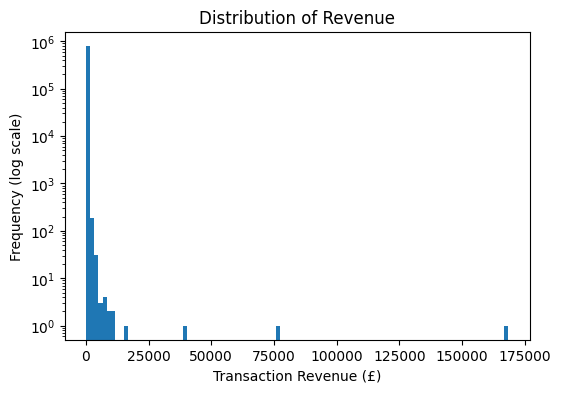

In [19]:
## Revenue distribution (log-scale)
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(clean["revenue"], bins=100)
plt.yscale("log")
plt.xlabel("Transaction Revenue (£)")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Revenue")
plt.show()


The transaction revenue distribution is highly right-skewed, with most transactions contributing relatively small amounts of revenue and a small number of extreme high-value transactions. This pattern is consistent with a mixed customer base that includes wholesale buyers placing bulk orders. As a result, mean-based metrics are not representative, motivating the use of robust feature scaling and log transformations in downstream modeling.


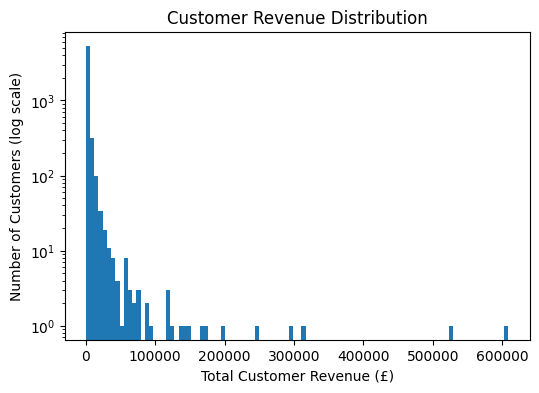

In [21]:
### Customer-level total spend
customer_revenue = (clean.groupby("customer_id")["revenue"].sum().sort_values(ascending=False))

plt.figure(figsize=(6,4))
plt.hist(customer_revenue, bins=100)
plt.yscale("log")
plt.xlabel("Total Customer Revenue (£)")
plt.ylabel("Number of Customers (log scale)")
plt.title("Customer Revenue Distribution")
plt.show()


Customer-level revenue exhibits a pronounced long-tail distribution, where a small subset of customers accounts for a disproportionate share of total revenue. This concentration highlights the importance of identifying and retaining high-value customers, and motivates the use of segmentation and CLV-based prioritization strategies.

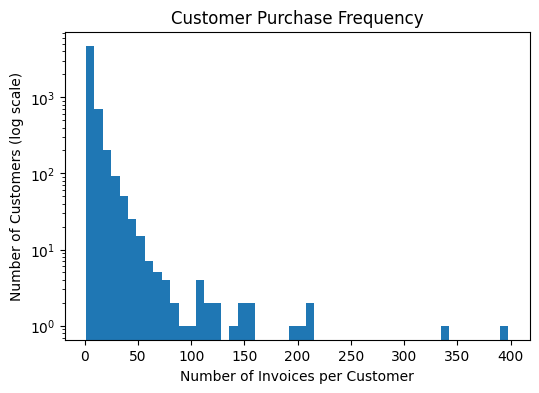

In [23]:
## Purchase frequency per customer
customer_freq = clean.groupby("customer_id")["invoice"].nunique()

plt.figure(figsize=(6,4))
plt.hist(customer_freq, bins=50)
plt.yscale("log")
plt.xlabel("Number of Invoices per Customer")
plt.ylabel("Number of Customers (log scale)")
plt.title("Customer Purchase Frequency")
plt.show()

Customer purchase frequency varies widely across the customer base. While many customers make only a small number of purchases, a minority exhibit highly frequent purchasing behavior, indicating strong engagement and potential wholesale activity. This variability suggests that frequency-based features will be highly informative for customer-level modeling.

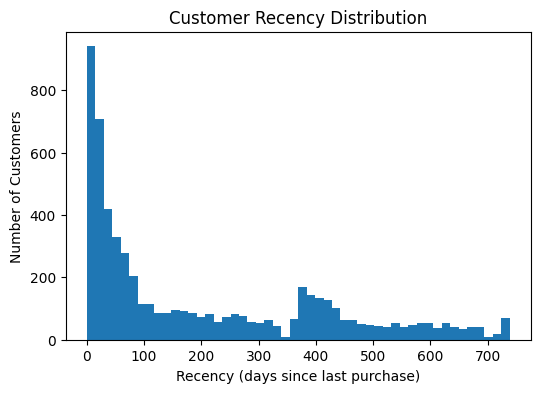

In [24]:
## Recency distribution
snapshot_date = clean["invoice_date"].max()

customer_recency = (
    snapshot_date - clean.groupby("customer_id")["invoice_date"].max()
).dt.days

plt.figure(figsize=(6,4))
plt.hist(customer_recency, bins=50)
plt.xlabel("Recency (days since last purchase)")
plt.ylabel("Number of Customers")
plt.title("Customer Recency Distribution")
plt.show()

Customer recency shows a broad distribution, ranging from very recent purchases to customers who have not purchased for over two years. This clear separation between active and inactive customers indicates that recency is a strong signal for customer engagement and potential churn risk.

#### EDA Summary

The exploratory analysis reveals substantial heterogeneity in customer behavior across revenue, purchase frequency, and recency. A small subset of customers drives a large share of revenue, while engagement levels vary significantly across the customer base. These patterns strongly justify customer-level feature engineering and motivate downstream segmentation, churn prediction, and CLV modeling.


## Customer-Level Feature Engineering

To support downstream segmentation, churn analysis, and lifetime value estimation, transaction-level data is aggregated into customer-level behavioral features. These features summarize purchasing behavior across three key dimensions: recency, frequency, and monetary value.


In [25]:
snapshot_date = clean["invoice_date"].max()
snapshot_date

Timestamp('2011-12-09 12:50:00')

In [26]:
## RFM Features
customer_features = (
    clean
    .groupby("customer_id")
    .agg(
        recency_days=("invoice_date", lambda x: (snapshot_date - x.max()).days),
        frequency_invoices=("invoice", "nunique"),
        monetary=("revenue", "sum"),
        avg_order_value=("revenue", "mean"),
        avg_items_per_invoice=("quantity", "mean"),
        active_months=("invoice_date", lambda x: x.dt.to_period("M").nunique()),
        last_purchase=("invoice_date", "max")
    )
    .reset_index()
)

customer_features.head()


,customer_id,recency_days,frequency_invoices,monetary,avg_order_value,avg_items_per_invoice,active_months,last_purchase
0,12346.0,325,12,77556.46,2281.072353,2184.852941,5,2011-01-18 10:01:00
1,12347.0,1,8,5633.32,22.266087,12.988142,8,2011-12-07 15:52:00
2,12348.0,74,5,2019.40,39.596078,53.215686,5,2011-09-25 13:13:00
3,12349.0,18,4,4428.69,25.306800,9.280000,4,2011-11-21 09:51:00
4,12350.0,309,1,334.40,19.670588,11.588235,1,2011-02-02 16:01:00


In [28]:
customer_features.info()

<class 'pandas.DataFrame'>
RangeIndex: 5878 entries, 0 to 5877
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_id            5878 non-null   float64       
 1   recency_days           5878 non-null   int64         
 2   frequency_invoices     5878 non-null   int64         
 3   monetary               5878 non-null   float64       
 4   avg_order_value        5878 non-null   float64       
 5   avg_items_per_invoice  5878 non-null   float64       
 6   active_months          5878 non-null   int64         
 7   last_purchase          5878 non-null   datetime64[us]
dtypes: datetime64[us](1), float64(4), int64(3)
memory usage: 367.5 KB


In [30]:
customer_features.describe().T

,count,mean,min,25%,50%,75%,max,std
customer_id,5878.0,15315.313542,12346.0,13833.25,15314.5,16797.75,18287.0,1715.572666
recency_days,5878.0,200.331916,0.0,25.0,95.0,379.0,738.0,209.338707
frequency_invoices,5878.0,6.289384,1.0,1.0,3.0,7.0,398.0,13.009406
monetary,5878.0,3018.616737,2.95,348.7625,898.915,2307.09,608821.65,14737.73104
avg_order_value,5878.0,48.299996,2.042182,11.470705,17.354064,24.195021,56157.5,780.177864
avg_items_per_invoice,5878.0,25.31436,1.0,5.593228,9.591973,14.150385,26999.0,365.027044
active_months,5878.0,4.354372,1.0,1.0,3.0,6.0,25.0,4.494052
last_purchase,5878,2011-05-22 16:19:59.469207,2009-12-01 09:55:00,2010-11-25 10:24:45,2011-09-05 11:59:00,2011-11-14 11:31:15,2011-12-09 12:50:00,NaN


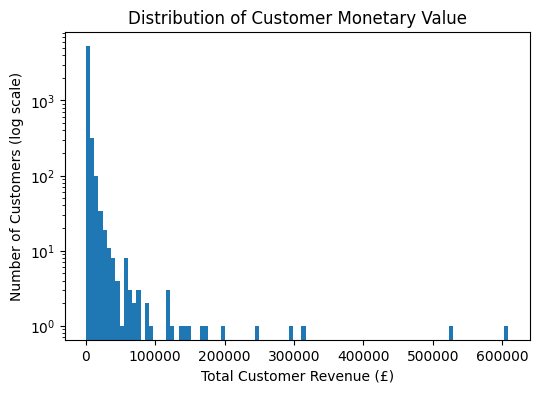

In [31]:
plt.figure(figsize=(6,4))
plt.hist(customer_features["monetary"], bins=100)
plt.yscale("log")
plt.xlabel("Total Customer Revenue (£)")
plt.ylabel("Number of Customers (log scale)")
plt.title("Distribution of Customer Monetary Value")
plt.show()


In [34]:
customer_features.to_csv("../data/processed/customer_features.csv", index=False)

## Customer Feature Insights

### Customer Activity
- 50% of customers have not purchased in the last **95 days**.
- ~25% of customers have been inactive for **over 1 year**.
- Only a small group of customers purchased very recently (within the last few days).

A large portion of customers are inactive, indicating clear opportunities for re-engagement and churn prevention.

---

### Purchase Frequency
- Median customer makes **3 purchases**.
- ~75% of customers make **7 or fewer purchases**.
- A small group of customers make **100+ purchases**, likely representing wholesale buyers.

Customer engagement varies widely and treating all customers the same would be inefficient.

---

### Revenue Contribution
- Median customer generates ~**£900** in revenue.
- Average revenue (~**£3,000**) is much higher due to a small number of high-value customers.
- A few customers generate **hundreds of thousands of pounds** in revenue.

Revenue is highly concentrated, and hence retaining a small number of high-value customers is critical to overall business performance.

---

### Customer Longevity
- Median customer is active for **3 months**.
- Some customers remain active for **over 2 years**.

This means long-term customers exist and should be identified for loyalty and retention programs.
